In [1]:
#%pylab inline
%matplotlib inline
from array import array
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from root_numpy.tmva import add_classification_events, evaluate_reader
from ROOT import TMVA, TFile, TCut
# Classify the test dataset with the classifier
reader = TMVA.Reader()
from root_numpy import root2array, rec2array
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.ranking import _binary_clf_curve

tree_prefix = '/Users/pigard/CMS/ZZ_analysis/'

branch_names = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta', 
                'costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2',      
               ]
signal = root2array(tree_prefix + 'EWK3_BLS.root',
                    "test",
                    branch_names)


backgr = root2array(tree_prefix + 'QCD3_BLS.root',
                    "test",
                    branch_names)




Welcome to ROOTaaS 6.05/02


In [7]:
from sklearn.cross_validation import train_test_split

def varset_training(estimator, sig, back, variable_names = []) :
    out_list = []
    
    for var in variable_names :
        print var
        
        red_back = rec2array(back[var])
        red_sig = rec2array(sig[var])
        
        X = np.concatenate((red_sig, red_back))
        y = np.concatenate((np.ones(sig.shape[0]) ,
                            np.zeros(back.shape[0])))
        
    
        X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                              test_size=0.33, random_state=42)
        X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                  test_size=0.33, random_state=492)
    
        est = copy.deepcopy(estimator)
        est.fit(X_train, y_train)
        
        est_decisions = est.decision_function(X_test)
        est_fpr, est_tpr, thresholds = roc_curve(y_test, est_decisions)
        
        out_list.append((var, est, est_fpr, est_tpr))
    return out_list

In [10]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import copy
gbdt = GradientBoostingClassifier(n_estimators=800, learning_rate =.1, max_depth=4, random_state=0)

classic_vbf = ['m_jj', 
                'dEta_tj', 
                'm_4l',
                'Z1_zepp', 
                'Z2_zepp', 
                'dPhi_Z1_Z2', 
                'tj1_eta_x_tj2_eta']
angles_only = [ 'costhetastar', 
                'phi', 
                'costheta1', 
                'costheta2', 
                'phi1',
                'vbf_costhetastar',
                'vbf_costheta1',
                'vbf_costheta2',
                'vbf_phi',
                'vbf_phi1',
                'qv1',
                'qv2',]

all_var = angles_only+classic_vbf
varsets = [classic_vbf, angles_only, all_var, all_var + ['jet_Dphi']]
result = varset_training(gbdt, signal, backgr, varsets)

['m_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta']
['costhetastar', 'phi', 'costheta1', 'costheta2', 'phi1', 'vbf_costhetastar', 'vbf_costheta1', 'vbf_costheta2', 'vbf_phi', 'vbf_phi1', 'qv1', 'qv2']
['costhetastar', 'phi', 'costheta1', 'costheta2', 'phi1', 'vbf_costhetastar', 'vbf_costheta1', 'vbf_costheta2', 'vbf_phi', 'vbf_phi1', 'qv1', 'qv2', 'm_jj', 'dEta_tj', 'm_4l', 'Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta']


In [14]:
from sklearn.metrics import auc


def plot_varset_training(result, labels = []) :
    for i in range(len(result)) :
        entry = result[i]
        fpr = entry[2]
        tpr = entry[3]
        plt.plot(fpr, tpr, lw=1, label=labels[i])
#plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, .45])
    plt.ylim([0.45, 1.05])
    plt.xlabel('background efficiency')
    plt.ylabel('signal efficiency')
    plt.title('ROC')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

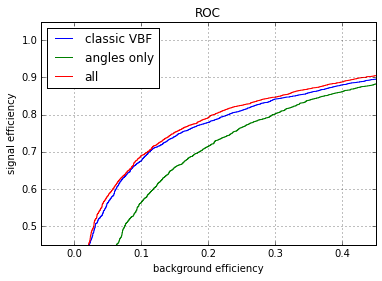

In [15]:
plot_varset_training(result, ('classic VBF', 'angles only', 'all'))

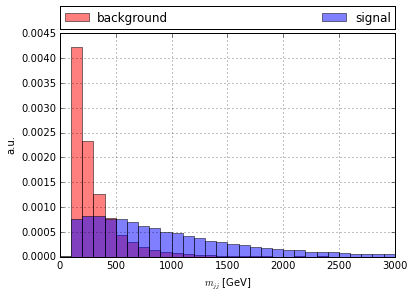

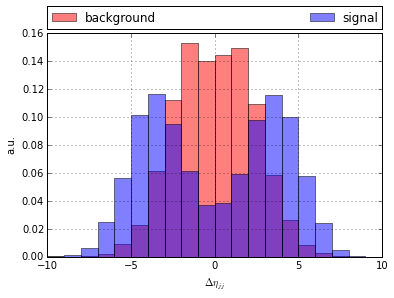

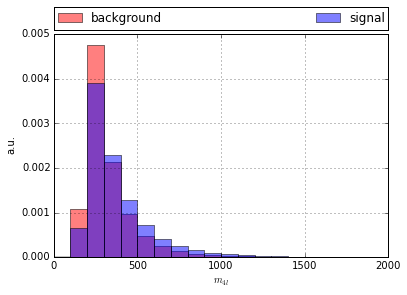

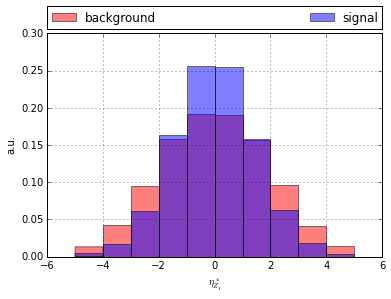

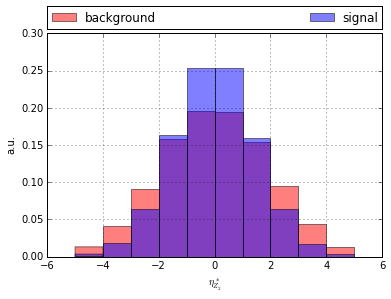

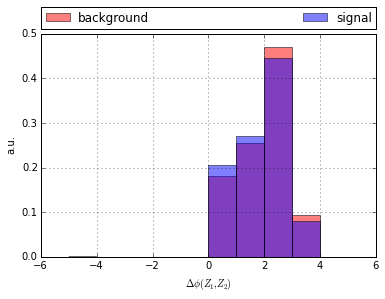

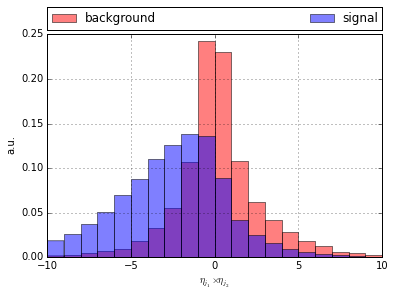

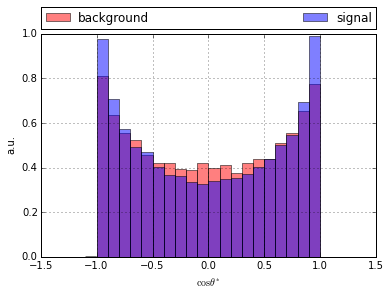

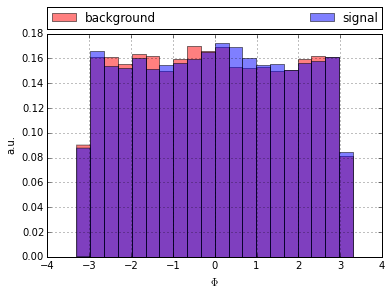

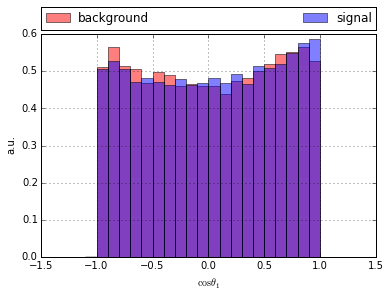

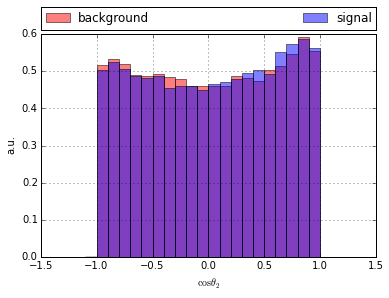

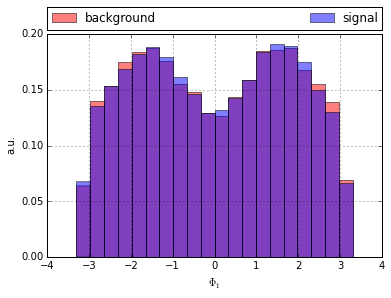

In [17]:
signal = rec2array(signal)
backgr = rec2array(backgr)
#'costhetastar', 'Phi', 'costheta1', 'costheta2', 'Phi1'
plots = [(r'$m_{jj}$ [GeV]', 30 , [0, 3000]),
         (r'$\Delta\eta_{jj}$', 20, [-10, 10]),
         (r'$m_{4l}$', 20, [0, 2000]),
         (r'$\eta^{*}_{Z_{1}}$', 10, [-5, 5]),
         (r'$\eta^{*}_{Z_{2}}$', 10, [-5, 5]),
         (r'$\Delta\phi(Z_{1}, Z_{2})$', 10, [-5,5]),
         (r'$\eta_{j_{1}}\times\eta_{j_{2}}$', 20, [-10, 10]),
         (r'$\cos{\theta^*}$', 22, [-1.1, 1.1]),
         (r'$\Phi$', 20, [-3.3, 3.3]),
         (r'$\cos \theta_1$', 22, [-1.1, 1.1]),
         (r'$\cos \theta_2$', 22, [-1.1, 1.1]),
         (r'$\Phi_1$', 20, [-3.3, 3.3]),
        ]
#fig = plt.figure()

 #'m_4l','Z1_zepp', 'Z2_zepp', 'dPhi_Z1_Z2', 'tj1_eta_x_tj2_eta'
#plt.subplots(2, 3)
for i in range(len(plots)) :
    #, i+1)
    p = plots[i]
    plt.hist(backgr[:,i], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, color = 'red', label='background')
    plt.hist(signal[:,i], bins=p[1], range=p[2], normed=1, lw=1, alpha=0.5, label='signal')
#plt.locator_params(nbins=10)
#plt.locator_params(axis='y',nbins=20)
#plt.plot(gbdt_fpr, gbdt_tpr, lw=1, label='GBDT')
#plt.xlim([-0.0, 0.45])
#plt.ylim([-0.05, 1.05])
    plt.xlabel(p[0])
    plt.ylabel('a.u.')
    #plt.title('Receiver operating characteristic')
    #plt.legend(loc="best")
    plt.legend().set_visible(False)
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    #plt.legend(numpoints=1)
    plt.grid()
    plt.show()